# Faces Vs. Non-Faces

Load the new dataset

In [1]:
import DatasetSplitter

training_data_50, training_labels_50, testing_data_50, testing_labels_50 = DatasetSplitter.splitDataNonFaces50()
training_data_100, training_labels_100, testing_data_100, testing_labels_100 = DatasetSplitter.splitDataNonFaces100()
training_data_200, training_labels_200, testing_data_200, testing_labels_200 = DatasetSplitter.splitDataNonFaces()
training_data_400, training_labels_400, testing_data_400, testing_labels_400 = DatasetSplitter.splitDataNonFaces400()

# Apply the LDA algorithm for two classes
We only use 1 eigenvector, because the number of used eigenvectors = number of classes - 1, where the number of classes = 2 (Faces & Non-Faces)

In [2]:
# The following code is the implementation of Linear Discriminant Analysis (LDA) but for 2 classes only 
# (The Sb matrix is the only difference between this and the code in LDA.ipynb).

import numpy as np
import scipy as sp
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

def get_split_data(training_data):
    mat = np.array(training_data)
    split_data = []
    split_data.append(mat[:200])
    split_data.append(mat[200:])
    return split_data

def get_class_means(split_data):
    class_means = []
    for class_matrix in split_data:
        class_means.append(np.mean(class_matrix, axis=0))
    return class_means

def get_centered_classes(split_data, class_means):
    centered_classes = []
    for class_matrix, class_mean in zip(split_data, class_means):
        centered_class = []
        for row in class_matrix:
            centered_class.append(row - class_mean)
        centered_classes.append(centered_class)
    return centered_classes

def get_between_class(class_means):
    Sb = np.outer((class_means[0] - class_means[1]), np.transpose(class_means[0] - class_means[1]))
    return Sb

def get_within_class(centered_classes):
    Sw = np.zeros((10304, 10304))
    for centered_class in centered_classes:
        mat = np.array(centered_class)
        Sw += np.dot(np.transpose(mat), mat)
    Sw_inverse = sp.linalg.pinv(Sw)
    return Sw_inverse

def get_eigens(Sw_inverse, Sb):
    eigenvalues, eigenvectors = np.linalg.eig(np.dot(Sw_inverse, Sb))
    return eigenvalues, eigenvectors

def get_U(eigenvalues, eigenvectors):
    sorted_indecies = np.argsort(eigenvalues)[::-1]
    sorted_eigen_vectors = eigenvectors[:,sorted_indecies]
    U = np.real(sorted_eigen_vectors[:,:1])
    return U

In [3]:
def LDA(training_data, training_labels, testing_data, testing_labels):
    split_data = get_split_data(training_data)
    class_means = get_class_means(split_data)
    centered_classes = get_centered_classes(split_data, class_means)
    Sb = get_between_class(class_means)
    Sw_inverse = get_within_class(centered_classes)
    eigenvalues, eigenvectors = get_eigens(Sw_inverse, Sb)
    projection_matrix = get_U(eigenvalues, eigenvectors)

    projected_training_data = np.dot(training_data , projection_matrix)
    projected_testing_data = np.dot(testing_data , projection_matrix)
    classifier = KNeighborsClassifier(1)
    classifier.fit(projected_training_data, training_labels)
    prediction = classifier.predict(projected_testing_data)

    correctly_classified = []
    incorrectly_classified = []

    for i in range(len(testing_labels)):
        if testing_labels[i] == 2:
            if testing_labels[i] == prediction[i]:
                correctly_classified.append(testing_data[i])
            else:
                incorrectly_classified.append(testing_data[i])

    print("Success cases:")
    for image in correctly_classified[:3]:
        reshaped_image = np.reshape(image, (112, 92))
        plt.imshow(reshaped_image, cmap='gray')
        plt.show()

    print("Failure cases:")
    for image in incorrectly_classified[:3]:
        reshaped_image = np.reshape(image, (112, 92))
        plt.imshow(reshaped_image, cmap='gray')
        plt.show()
    
    accuracy = accuracy_score(testing_labels, prediction)

    print ("Accuracy = ", accuracy * 100)

# Using 50 non-face images for training

Success cases:


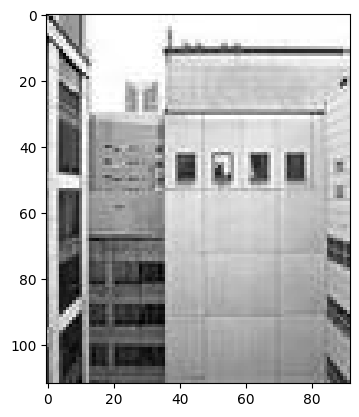

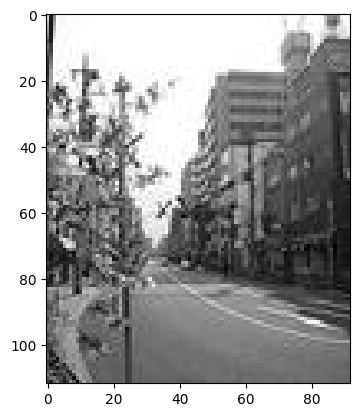

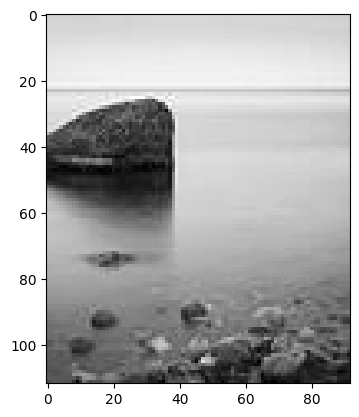

Failure cases:


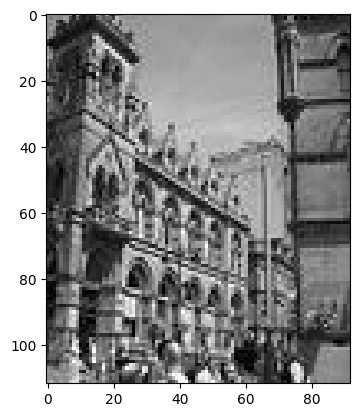

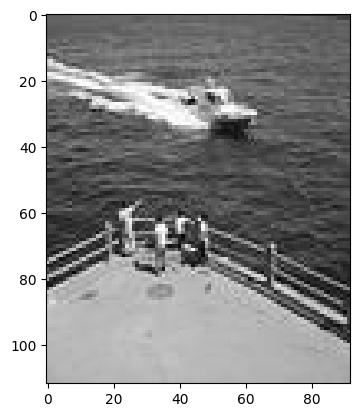

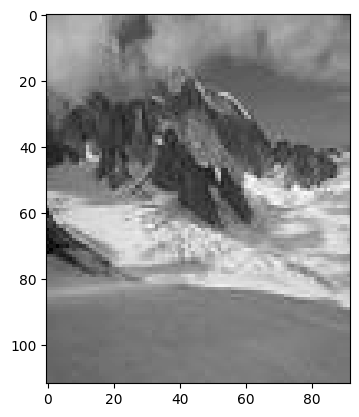

Accuracy =  91.25


In [12]:
LDA(training_data_50, training_labels_50, testing_data_50, testing_labels_50)

# Using 100 non-face images for training

Success cases:


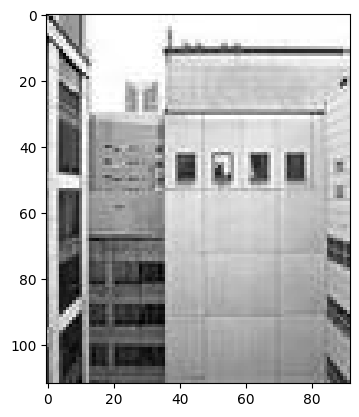

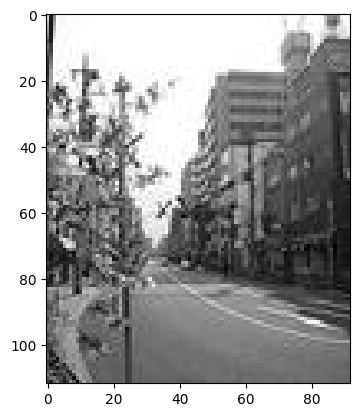

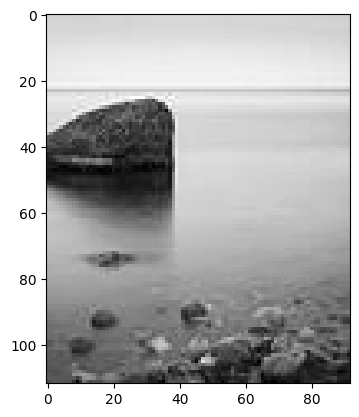

Failure cases:


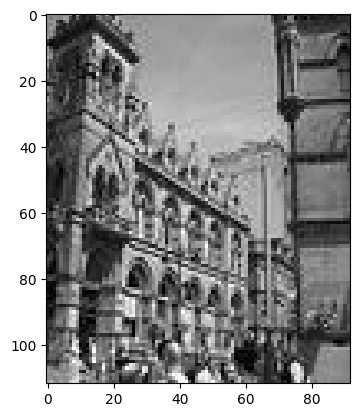

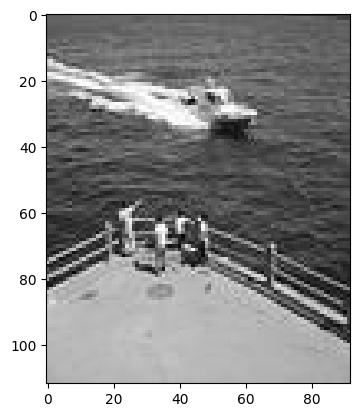

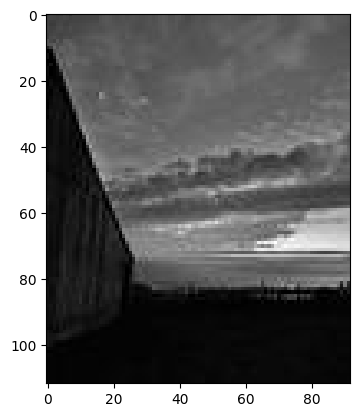

Accuracy =  93.5


In [13]:
LDA(training_data_100, training_labels_100, testing_data_100, testing_labels_100)

# Using 200 non-face images for training

Success cases:


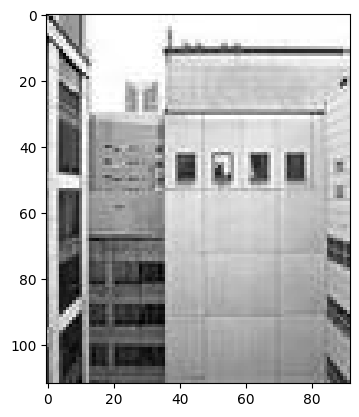

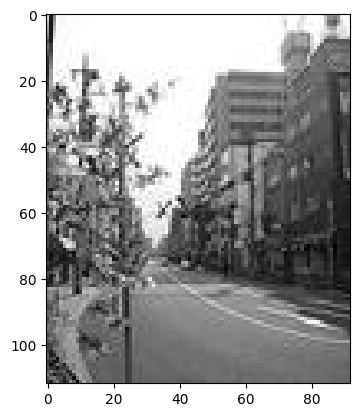

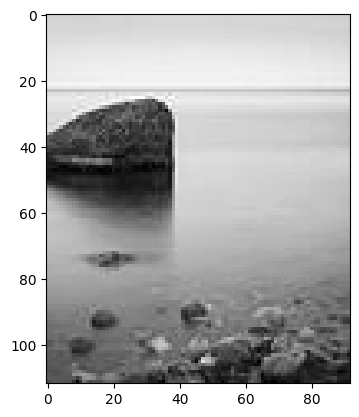

Failure cases:


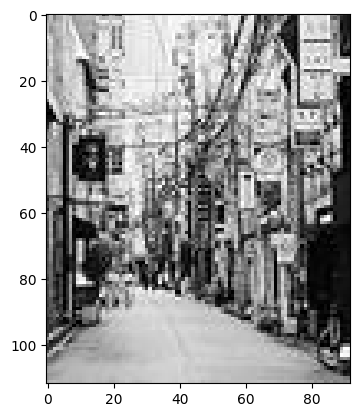

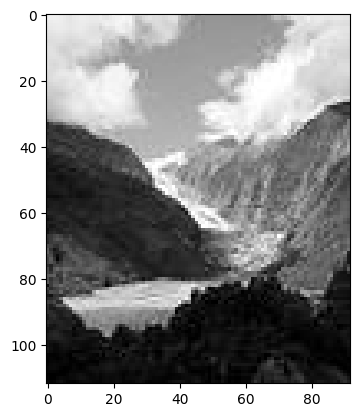

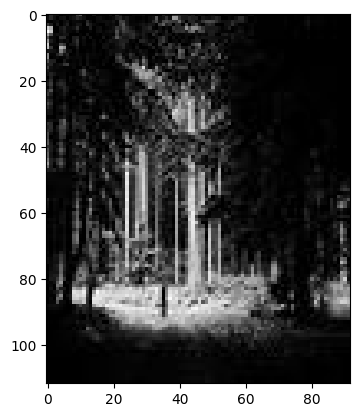

Accuracy =  89.5


In [15]:
LDA(training_data_200, training_labels_200, testing_data_200, testing_labels_200)

# Using 400 non-face images for training

Success cases:


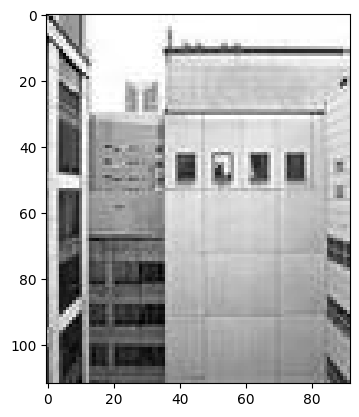

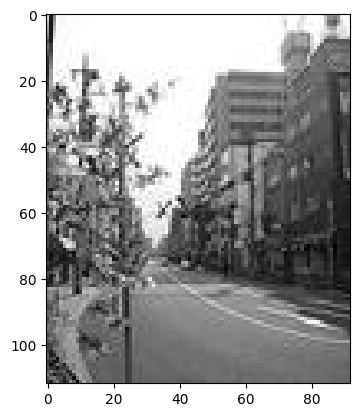

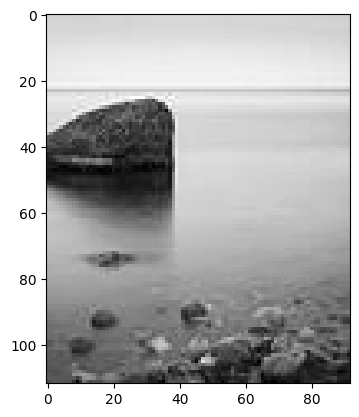

Failure cases:


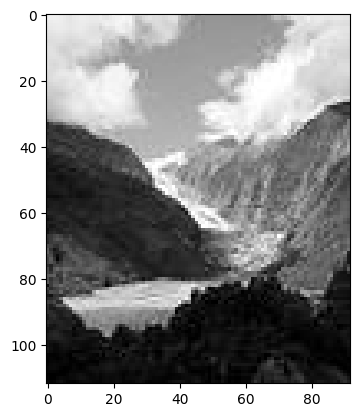

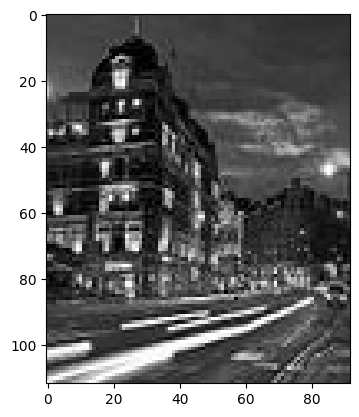

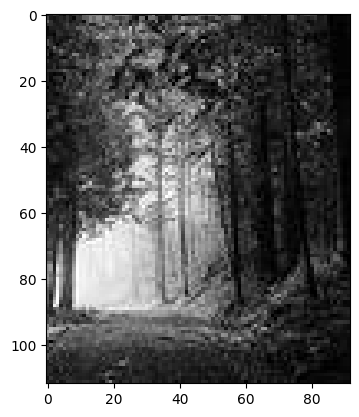

Accuracy =  92.75


In [16]:
LDA(training_data_400, training_labels_400, testing_data_400, testing_labels_400)

# Apply the PCA algorithm

In [5]:
def covariance(D):
    global mean_vector 
    mean_vector = np.mean(D, axis=0)
    Z = D - mean_vector
    cov = (1/len(D)) * (Z.T @ Z) 
    return cov

def PCA(D, alpha, trainingLabels, testingData, testingLabels):
    cov = covariance(D)
    eigenvalues, eigenvectors = np.linalg.eigh(cov)
    
    sorted_idx = eigenvalues.argsort()[::-1]  # Sort in descending order
    eigenvalues = eigenvalues[sorted_idx]
    eigenvectors = eigenvectors[:, sorted_idx]
    
    trace = np.trace(cov)
    c = 0 # Accumulator for sum of eigenvaleus
    lastIndex = 0
    for index in range(len(eigenvalues)):
        c += eigenvalues[index]
        if c / trace >= alpha :
            lastIndex = index
            break
    P = eigenvectors[:lastIndex + 1, :]# Projection Matrix
    # Project training data (correctly subtract mean before projection)
    projectedTrainingData = (D - mean_vector) @ P.T

    # Project testing data (correctly subtract mean before projection)
    projectedTestingData = (testingData - mean_vector) @ P.T

    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(projectedTrainingData, trainingLabels)

    predictedClasses = knn.predict(projectedTestingData)

    correctly_classified = []
    incorrectly_classified = []

    for i in range(len(testingLabels)):
        if testingLabels[i] == 2:
            if testingLabels[i] == predictedClasses[i]:
                correctly_classified.append(testingData[i])
            else:
                incorrectly_classified.append(testingData[i])

    print("Success cases:")
    for image in correctly_classified[:3]:
        reshaped_image = np.reshape(image, (112, 92))
        plt.imshow(reshaped_image, cmap='gray')
        plt.show()

    print("Failure cases:")
    for image in incorrectly_classified[:3]:
        reshaped_image = np.reshape(image, (112, 92))
        plt.imshow(reshaped_image, cmap='gray')
        plt.show()

    accuracy = accuracy_score(testingLabels, predictedClasses)

    print(f"Accuracy {100 * (accuracy)}")

# Using 50 non-face images for training

Success cases:


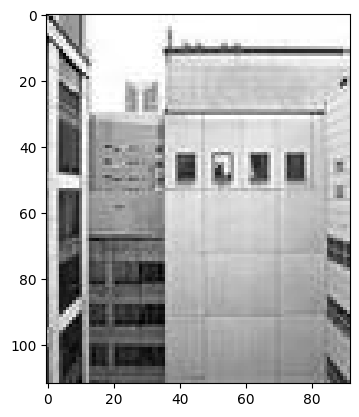

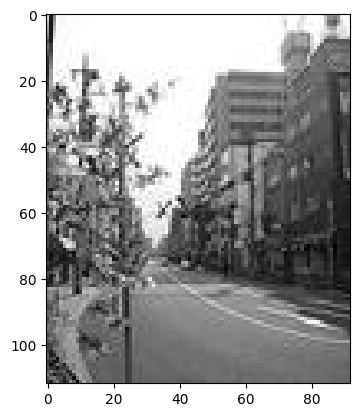

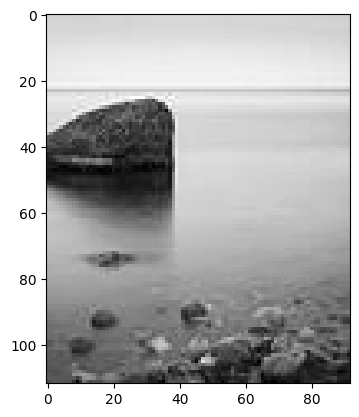

Failure cases:


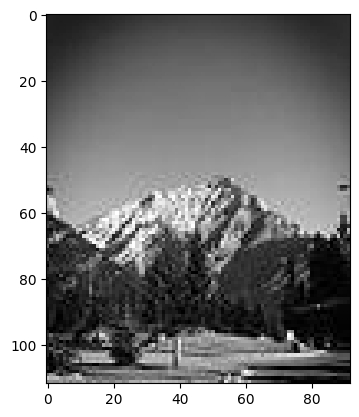

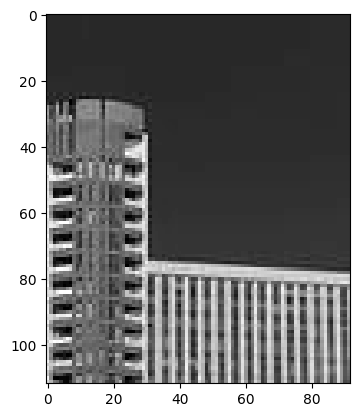

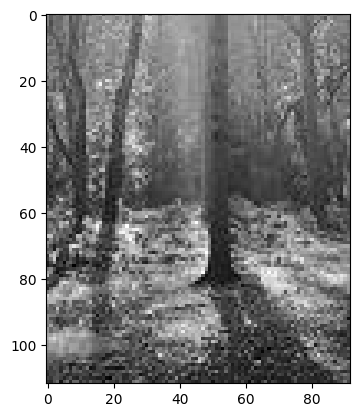

Accuracy 89.25


In [7]:
PCA(training_data_50, 0.95, training_labels_50, testing_data_50, testing_labels_50)

# Using 100 non-face images for training

Success cases:


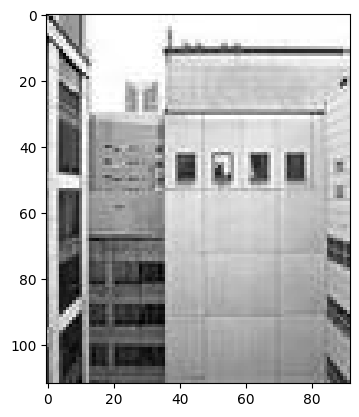

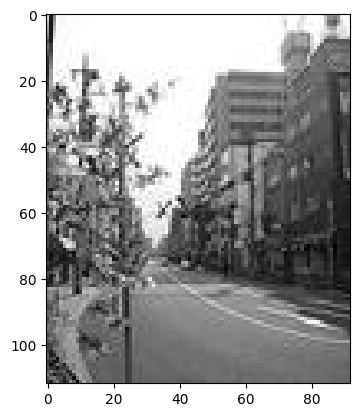

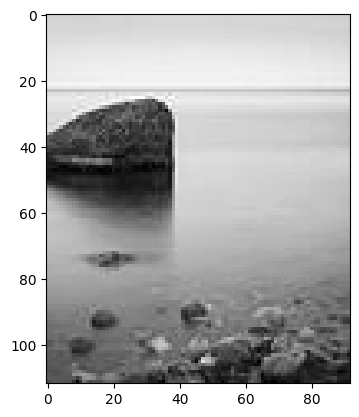

Failure cases:


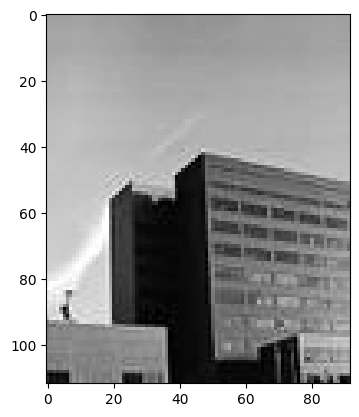

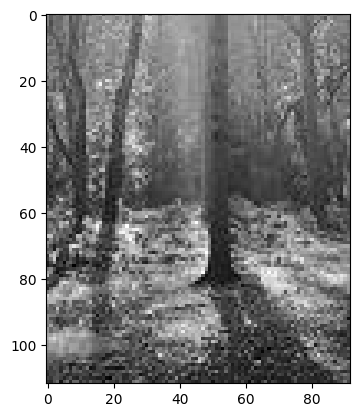

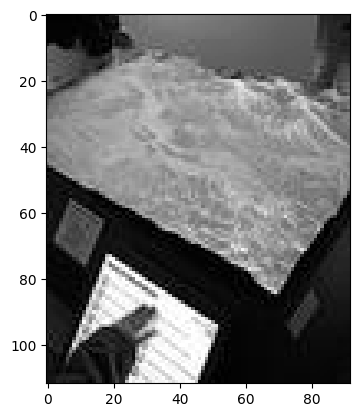

Accuracy 91.0


In [8]:
PCA(training_data_100, 0.95, training_labels_100, testing_data_100, testing_labels_100)

# Using 200 non-face images for training

Success cases:


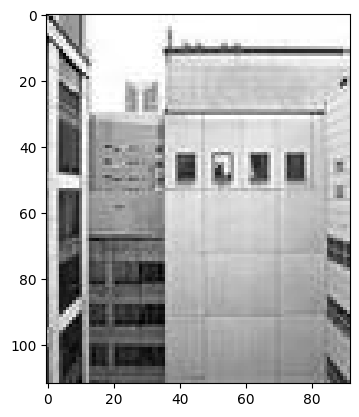

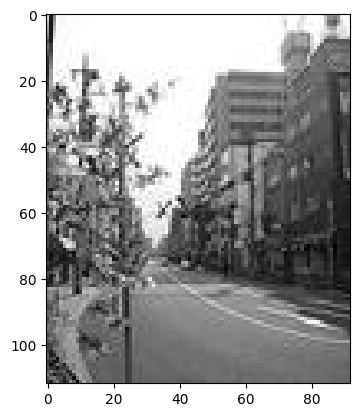

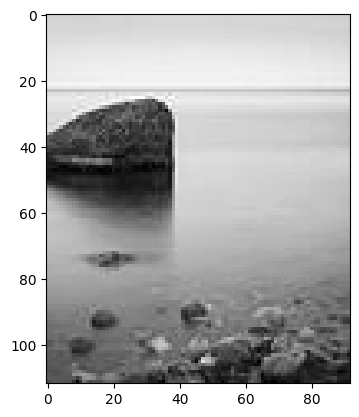

Failure cases:


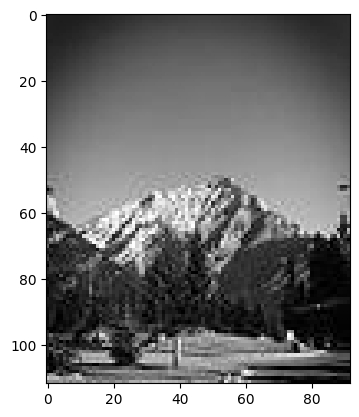

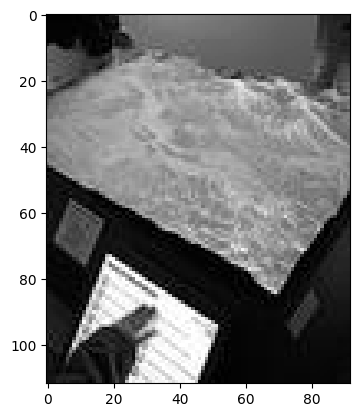

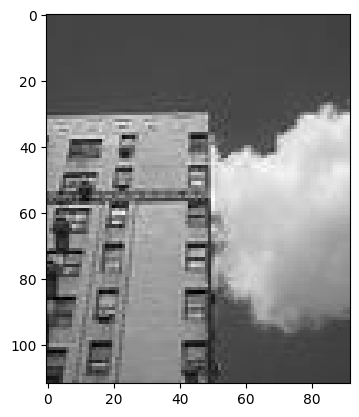

Accuracy 92.25


In [9]:
PCA(training_data_200, 0.95, training_labels_200, testing_data_200, testing_labels_200)

# Using 400 non-face images for training

Success cases:


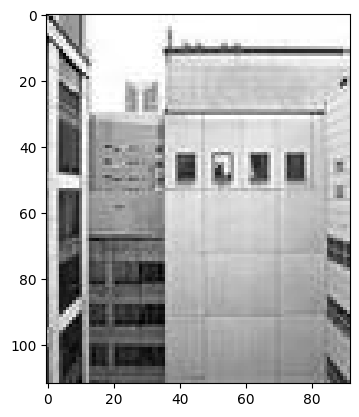

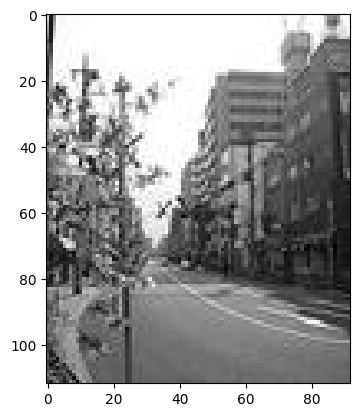

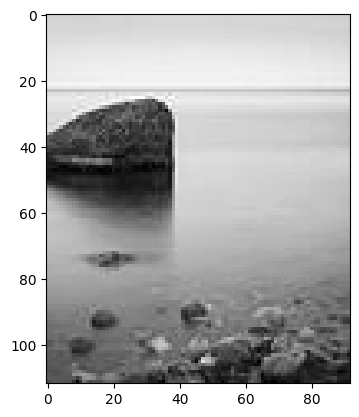

Failure cases:


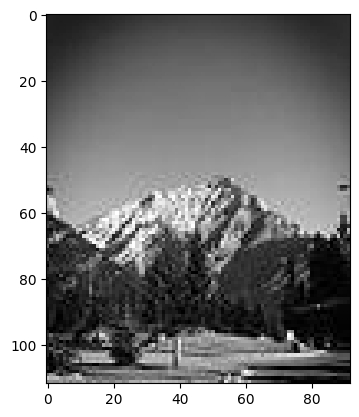

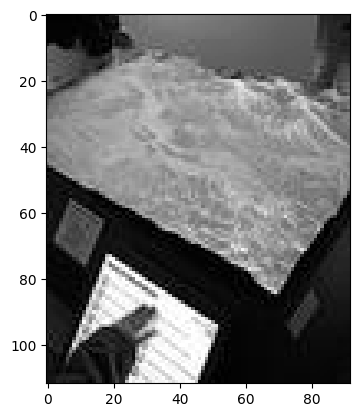

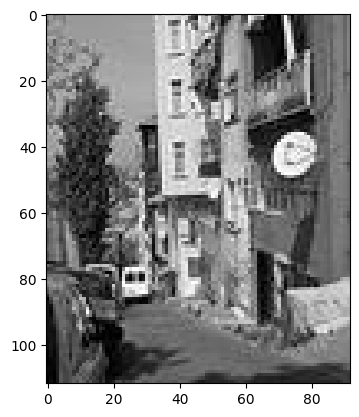

Accuracy 92.75


In [10]:
PCA(training_data_400, 0.95, training_labels_400, testing_data_400, testing_labels_400)

# LDA Accuracy while fixing 200 faces in the training set

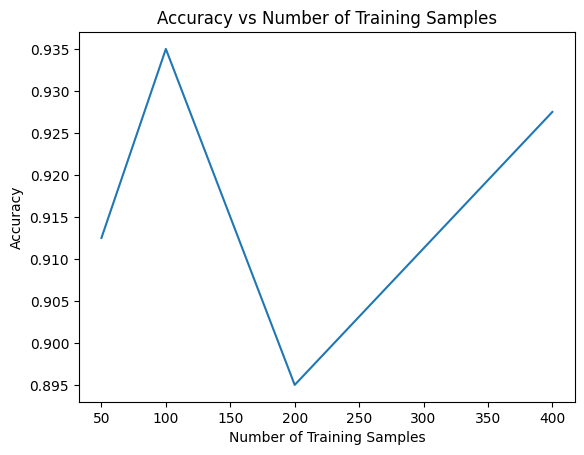

In [11]:
# List of training sample sizes
training_samples = [50, 100, 200, 400]

# List of corresponding accuracy values
accuracy = [0.9125, 0.935, 0.895, 0.9275]

# Plotting the graph
plt.plot(training_samples, accuracy)
plt.xlabel('Number of Training Samples')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Number of Training Samples')
plt.show()


# PCA Accuracy while fixing 200 faces in the training set

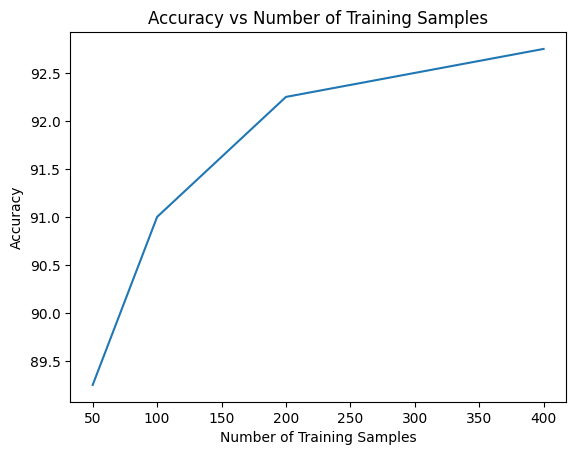

In [12]:
# List of training sample sizes
training_samples = [50, 100, 200, 400]

# List of corresponding accuracy values
accuracy = [89.25, 91, 92.25, 92.75]

# Plotting the graph
plt.plot(training_samples, accuracy)
plt.xlabel('Number of Training Samples')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Number of Training Samples')
plt.show()